In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from scipy import stats

from evaluator import Evaluator

In [3]:
def calculateDistributionMetrics(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Calculate distribution metrics for user activity, item popularity, and playtime.

    :param train_df: DataFrame with training data
    :param val_df: DataFrame with validation data
    :param test_df: DataFrame with test data

    :return: Dictionary with distribution metrics
    """
    metrics = {}
    
    # User activity distribution
    train_activity = train_df.groupby('user_id')['item_id'].count()
    val_activity = val_df.groupby('user_id')['item_id'].count()
    test_activity = test_df.groupby('user_id')['item_id'].count()
    
    # Item popularity distribution
    train_pop = train_df['item_id'].value_counts(normalize=True)
    val_pop = val_df['item_id'].value_counts(normalize=True)
    test_pop = test_df['item_id'].value_counts(normalize=True)
    
    # Playtime distribution
    train_play = train_df['playtime']
    val_play = val_df['playtime']
    test_play = test_df['playtime']

    def jensen_shannon(p, q):
        """Calculate Jensen-Shannon distance between two distributions."""
        # Calculate the mean of the two distributions
        m = 0.5 * (p + q)
        # Calculate Jensen-Shannon divergence
        divergence = 0.5 * (stats.entropy(p, m) + stats.entropy(q, m))
        # Return the square root of the divergence (to get the distance)
        return np.sqrt(divergence)
    
    # Calculate KL divergence and JS distance for each distribution
    for name, train_dist, val_dist, test_dist in [
        ('activity', train_activity, val_activity, test_activity),
        ('popularity', train_pop, val_pop, test_pop),
        ('playtime', train_play, val_play, test_play)
    ]:
        # Create histogram distributions for comparison
        hist_range = (min(train_dist.min(), val_dist.min(), test_dist.min()),
                max(train_dist.max(), val_dist.max(), test_dist.max()))
        
        train_hist, _ = np.histogram(train_dist, bins=50, range=hist_range, density=True)
        val_hist, _ = np.histogram(val_dist, bins=50, range=hist_range, density=True)
        test_hist, _ = np.histogram(test_dist, bins=50, range=hist_range, density=True)
        
        # Add small epsilon to avoid division by zero
        epsilon = 1e-10
        train_hist = train_hist + epsilon
        val_hist = val_hist + epsilon
        test_hist = test_hist + epsilon
        
        # Normalize
        train_hist = train_hist / train_hist.sum()
        val_hist = val_hist / val_hist.sum()
        test_hist = test_hist / test_hist.sum()
        
        # Calculate KL divergence
        kl_val_test = stats.entropy(val_hist, test_hist)
        kl_train_test = stats.entropy(train_hist, test_hist)
    
        js_val_test = jensen_shannon(val_hist, test_hist)
        js_train_test = jensen_shannon(train_hist, test_hist)
        
        metrics[f'{name}_kl_val_test'] = kl_val_test
        metrics[f'{name}_kl_train_test'] = kl_train_test
        metrics[f'{name}_js_val_test'] = js_val_test
        metrics[f'{name}_js_train_test'] = js_train_test
        
    return metrics

In [4]:
def createValidationPlots(train_df: pd.DataFrame, val_in_df: pd.DataFrame, 
                             val_out_df: pd.DataFrame, test_df: pd.DataFrame):
    """
    Create visualizations to validate the data splits.

    :param train_df: DataFrame with the training interactions.
    :param val_in_df: DataFrame with the validation interactions for training history.
    :param val_out_df: DataFrame with the validation interactions for future interactions.
    :param test_df: DataFrame with the test interactions.
    """
    sns.set(style="whitegrid", font="Arial", context="talk")
    colors = sns.color_palette("Set2")
    
    fig, axes = plt.subplots(2, 2, figsize=(20, 16))
    fig.patch.set_facecolor('white')
    
    TITLE_SIZE = 18
    LABEL_SIZE = 14
    TICK_SIZE = 12
    LEGEND_SIZE = 12
    
    def style_axis(ax, title, xlabel, ylabel):
        ax.set_title(title, fontsize=TITLE_SIZE, pad=20, fontweight='bold')
        ax.set_xlabel(xlabel, fontsize=LABEL_SIZE)
        ax.set_ylabel(ylabel, fontsize=LABEL_SIZE)
        ax.tick_params(labelsize=TICK_SIZE)
        ax.grid(True, linestyle='--', alpha=0.7)
        for spine in ax.spines.values():
            spine.set_linewidth(1.2)
    
    # User Activity Distribution (top left)
    ax1 = axes[0, 0]
    train_activity = train_df.groupby('user_id')['item_id'].count()
    val_activity = pd.concat([
        val_in_df.groupby('user_id')['item_id'].count(),
        val_out_df.groupby('user_id')['item_id'].count()
    ])
    test_activity = test_df.groupby('user_id')['item_id'].count()
    
    sns.kdeplot(data=train_activity, label='Training Set', ax=ax1, color=colors[0], linewidth=3)
    sns.kdeplot(data=val_activity, label='Validation Set', ax=ax1, color=colors[1], linewidth=3)
    sns.kdeplot(data=test_activity, label='Test Set', ax=ax1, color=colors[2], linewidth=3)
    
    style_axis(ax1, 
               'User Activity Distribution',
               'Log Interactions per User',
               'Density')
    ax1.set_xscale('log')
    ax1.legend(fontsize=LEGEND_SIZE, loc='upper right', frameon=False)
    
    # Item Popularity Distribution (top right)
    ax2 = axes[0, 1]
    train_pop = train_df['item_id'].value_counts(normalize=True)
    val_pop = pd.concat([val_in_df, val_out_df])['item_id'].value_counts(normalize=True)
    test_pop = test_df['item_id'].value_counts(normalize=True)
    
    sns.kdeplot(data=train_pop, label='Training Set', ax=ax2, color=colors[0], linewidth=3)
    sns.kdeplot(data=val_pop, label='Validation Set', ax=ax2, color=colors[1], linewidth=3)
    sns.kdeplot(data=test_pop, label='Test Set', ax=ax2, color=colors[2], linewidth=3)
    
    style_axis(ax2,
               'Item Popularity Distribution',
               'Log Normalized Frequency',
               'Density')
    ax2.set_xscale('log')
    ax2.legend(fontsize=LEGEND_SIZE, loc='upper right', frameon=False)
    
    # Fold Split Analysis (bottom left)
    ax3 = axes[1, 0]
    val_in_items = val_in_df.groupby('user_id')['item_id'].count()
    val_out_items = val_out_df.groupby('user_id')['item_id'].count()
    
    split_data = pd.DataFrame({
        'Number of Items': pd.concat([val_in_items, val_out_items]),
        'Split Type': ['Training History'] * len(val_in_items) + 
                      ['Future Interactions'] * len(val_out_items)
    })
    
    sns.violinplot(data=split_data, x='Split Type', y='Number of Items', 
                   ax=ax3, palette=colors[:2], inner='quartile')
    
    style_axis(ax3,
               'Validation Split Analysis',
               'Split Type',
               'Items per User')
    
    # Playtime Distribution (bottom right)
    ax4 = axes[1, 1]
    max_playtime = np.percentile(pd.concat([
        train_df['playtime'],
        val_in_df['playtime'],
        val_out_df['playtime'],
        test_df['playtime']
    ]), 99)
    
    sns.kdeplot(data=np.clip(train_df['playtime'], 0, max_playtime), 
                label='Training Set', ax=ax4, color=colors[0], linewidth=3)
    sns.kdeplot(data=np.clip(pd.concat([val_in_df, val_out_df])['playtime'], 0, max_playtime),
                label='Validation Set', ax=ax4, color=colors[1], linewidth=3)
    sns.kdeplot(data=np.clip(test_df['playtime'], 0, max_playtime),
                label='Test Set', ax=ax4, color=colors[2], linewidth=3)
    
    style_axis(ax4,
               'Playtime Distribution',
               'Clipped Playtime (99th Percentile)',
               'Density')
    ax4.legend(fontsize=LEGEND_SIZE, loc='upper right', frameon=False)
    
    plt.suptitle('Data Validation Visualizations', 
                 fontsize=22, y=1.05, fontweight='bold')
    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\n=== Split Validation Summary ===")
    print("\nUser Activity Statistics:")
    print(f"Median interactions per user:")
    print(f"  Training Set: {train_activity.median():.1f}")
    print(f"  Validation Set: {val_activity.median():.1f}")
    print(f"  Test Set: {test_activity.median():.1f}")
    
    print("\nFold Split Statistics:")
    print(f"Average items per user:")
    print(f"  Training History: {val_in_items.mean():.1f}")
    print(f"  Future Interactions: {val_out_items.mean():.1f}")
    print(f"Split Ratio (Training:Future): {val_in_items.sum()/val_out_items.sum():.2f}")


{'activity_kl_val_test': 0.06252683384075075, 'activity_kl_train_test': 0.03739137776585875, 'activity_js_val_test': 0.1381178338191485, 'activity_js_train_test': 0.08182139633069994, 'popularity_kl_val_test': 0.2054560424314366, 'popularity_kl_train_test': 0.011387729851284025, 'popularity_js_val_test': 0.1382028915216112, 'popularity_js_train_test': 0.02343347334103629, 'playtime_kl_val_test': 0.001519986631584476, 'playtime_kl_train_test': 0.00012663718018977592, 'playtime_js_val_test': 0.02087126440181322, 'playtime_js_train_test': 0.005359715817796175}


/var/folders/72/8jdf9_gd0v53f39flm35_76h0000gn/T/ipykernel_12065/1060553899.py:79: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=split_data, x='Split Type', y='Number of Items',


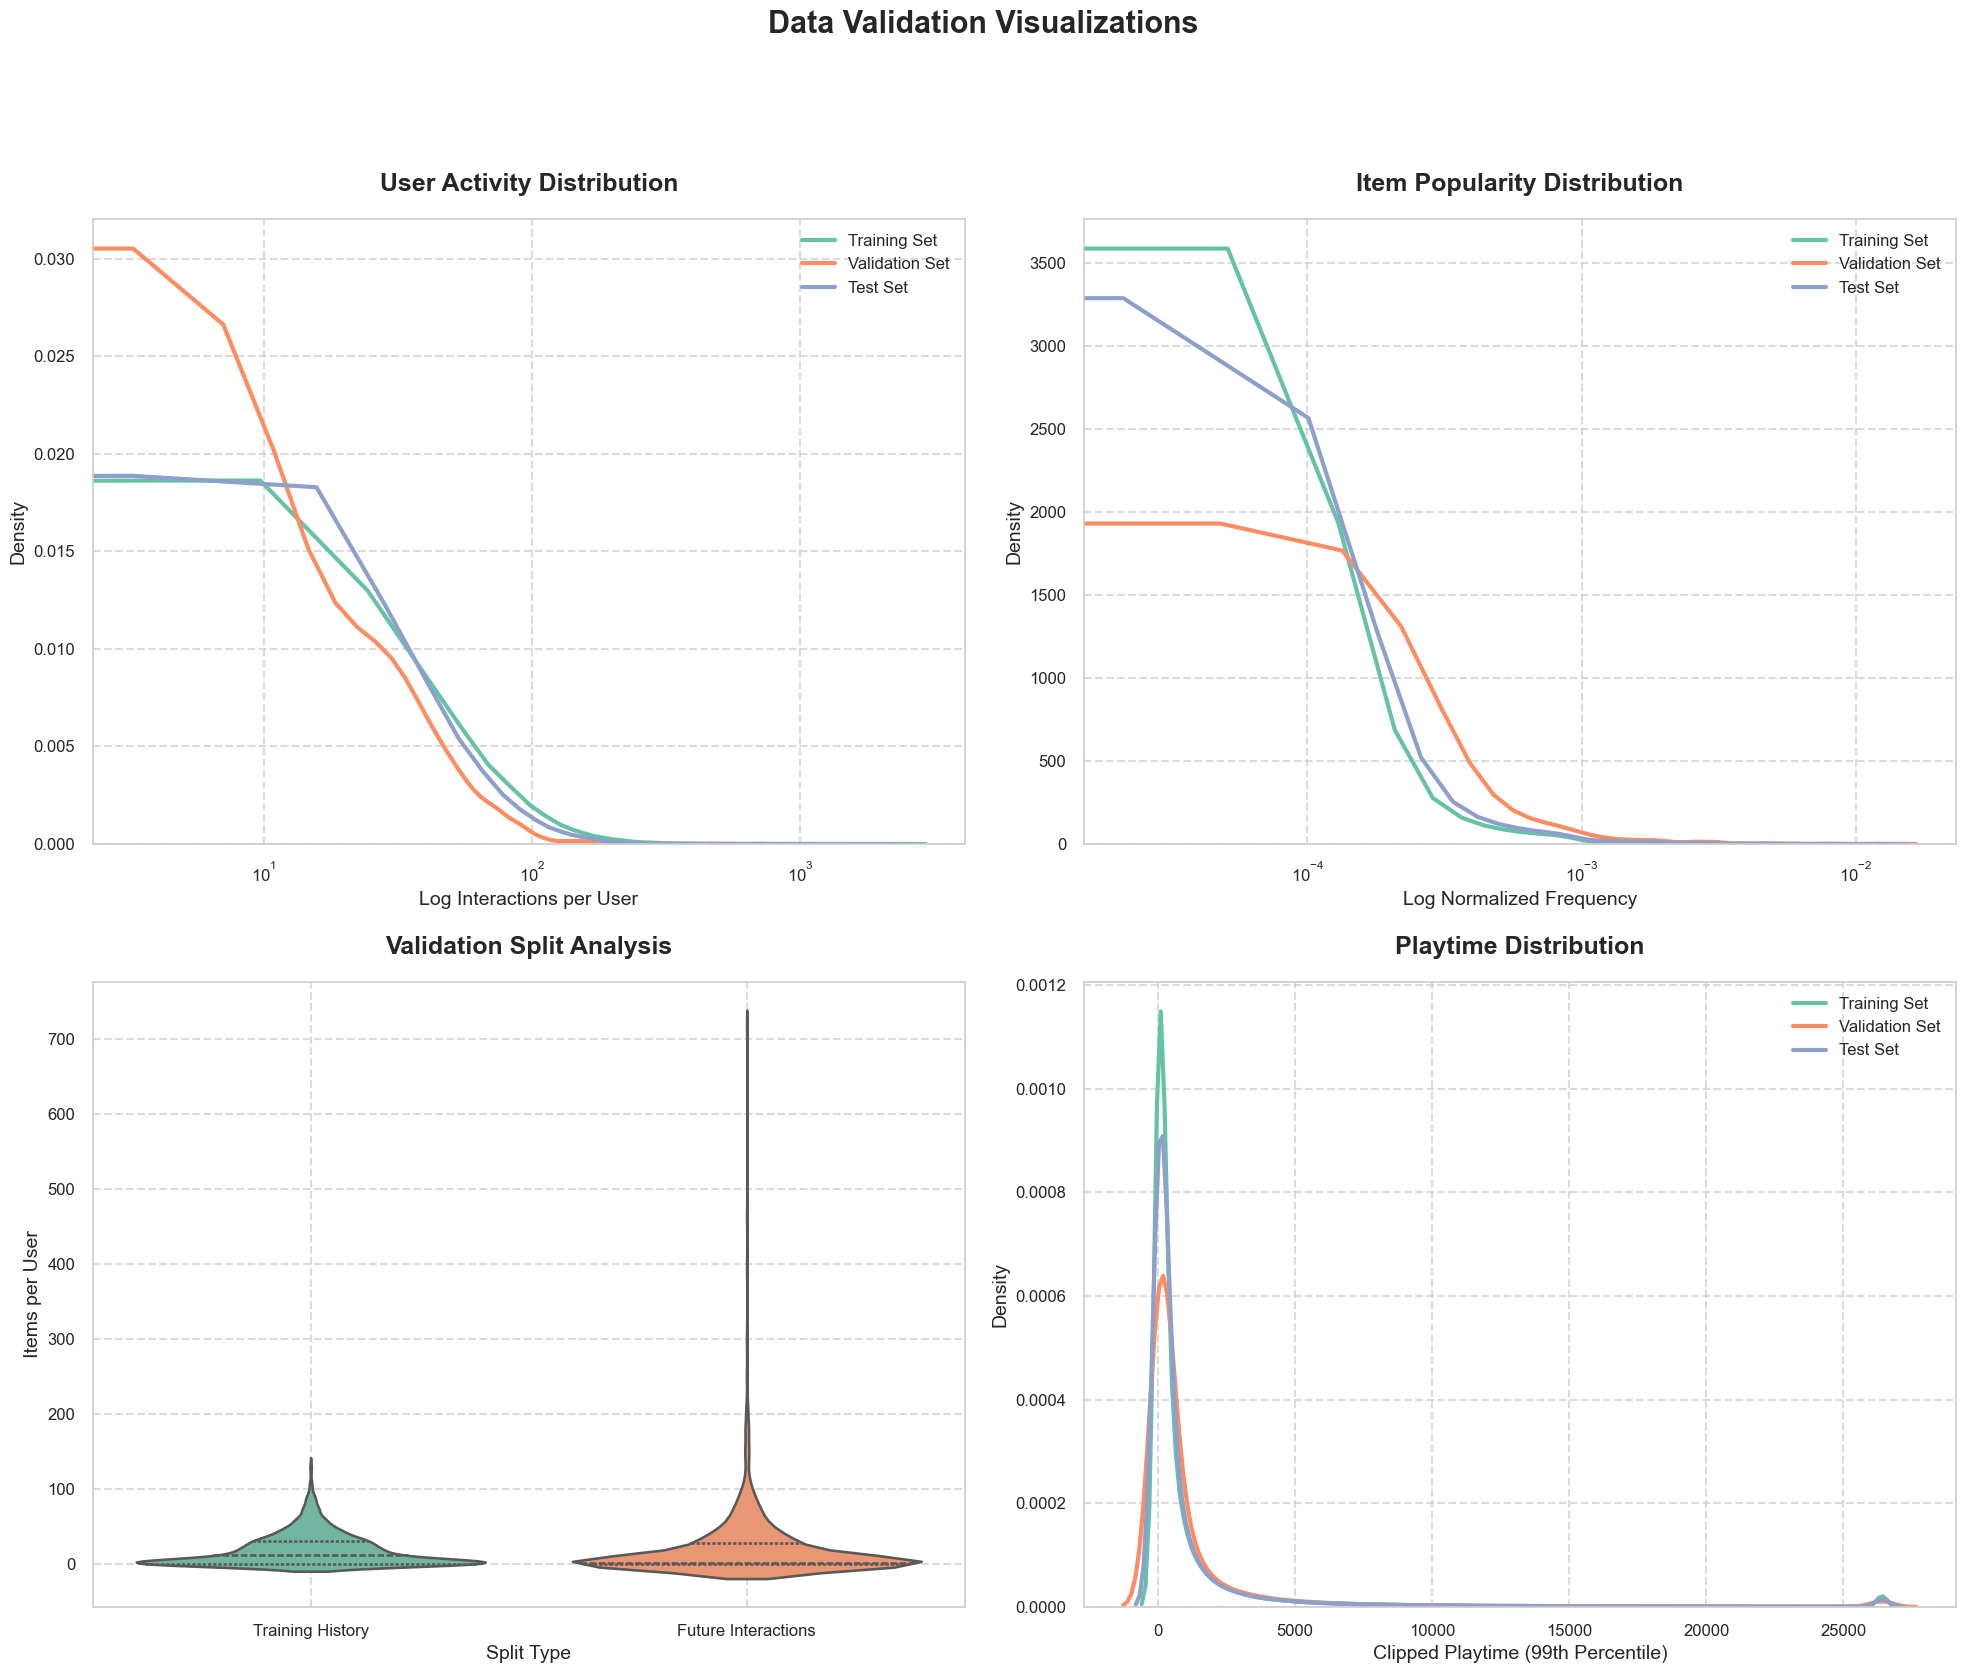


=== Split Validation Summary ===

User Activity Statistics:
Median interactions per user:
  Training Set: 26.0
  Validation Set: 8.0
  Test Set: 20.0

Fold Split Statistics:
Average items per user:
  Training History: 19.4
  Future Interactions: 22.1
Split Ratio (Training:Future): 0.88


In [5]:
evaluator = Evaluator(
    '../data/raw/train_interactions.csv', '../data/raw/test_interactions_in.csv')

train_data = evaluator.createSampledDataset(evaluator.train_df, 7500, seed=42)

# Create splits using your existing methods
train_split, val_split = evaluator.createValidationSplit(
    train_data, 
    val_size=0.2, 
    seed=42
)

# Create fold splits
val_in, val_out = evaluator.createFoldInSplit(val_split, seed=42)

# Calculate distribution metrics
metrics = calculateDistributionMetrics(train_split, val_in, evaluator.test_in_df)
print(metrics)

createValidationPlots(evaluator.train_df, val_in, val_out, evaluator.test_in_df)

In [6]:
def createItemGraphsFixed(item_data, normalize_weights=False, figsize=(20, 10)) -> plt:
    """
    Creates bipartite network visualizations with fixed positions.

    :param item_data: A dictionary where keys are user IDs and values are dictionaries of item IDs and weights.
    :param normalize_weights: If True, normalize the weights for each user.
    :param figsize: The size of the figure.

    :return: The matplotlib plot object.
    """
    G = nx.Graph()
    
    # Add nodes
    users = list(item_data.keys())
    items = list(set([item for user_items in item_data.values() 
                     for item in user_items.keys()]))
    
    G.add_nodes_from(users, bipartite=0)
    G.add_nodes_from(items, bipartite=1)
    
    # Process edges and weights
    edges = []
    weights = []
    edge_labels = {}
    
    for user in item_data:
        user_weights = []
        for item, weight in item_data[user].items():
            edges.append((user, item))
            user_weights.append(weight)
        
        if normalize_weights:
            total_weight = sum(user_weights)
            user_weights = [w/total_weight for w in user_weights]
            
        weights.extend(user_weights)
        
        for (item, weight), normalized_weight in zip(item_data[user].items(), user_weights):
            if normalize_weights:
                edge_labels[(user, item)] = f'{normalized_weight:.2f}'
            else:
                edge_labels[(user, item)] = f'{weight}'
    
    for edge, weight in zip(edges, weights):
        G.add_edge(*edge, weight=weight)
    
    plt.figure(figsize=figsize)
    
    # Create fixed positions
    pos = {}
    # Position users on the left
    for i, user in enumerate(users):
        pos[user] = np.array([0, (len(users)-i-1)/(len(users)-1)])
    
    # Position items on the right in two columns
    for i, item in enumerate(items):
        if i < len(items)//2:
            pos[item] = np.array([1, (len(items)//2-i-1)/(len(items)//2-1)])
        else:
            pos[item] = np.array([1.2, (len(items)-i-1)/(len(items)-len(items)//2-1)])
    
    # Draw the graph
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=users, 
                          node_color='lightblue',
                          node_size=500,
                          label='Users')
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=items, 
                          node_color='lightgreen',
                          node_size=500,
                          label='Items')
    
    max_weight = max(weights)
    edge_widths = [2 * w/max_weight for w in weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
    
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    title = 'User-Item Network with Weights'
    if normalize_weights:
        title = 'User-Item Network with Transition Probabilities'
    plt.title(title)
    plt.legend()
    
    return plt

In [7]:
def createItemGraphs(item_data, normalize_weights=False, figsize=(20, 10)) -> plt:
    """
    Creates a bipartite graph of users and items with weights as edge weights.

    :param item_data: A dictionary where keys are user IDs and values are dictionaries of item IDs and weights.
    :param normalize_weights: If True, normalize the weights for each user.
    :param figsize: The size of the figure.

    :return: The matplotlib plot object.
    """
    # Create graph
    G = nx.Graph()
    
    # Add nodes
    users = list(item_data.keys())
    items = list(set([item for user_items in item_data.values() 
                     for item in user_items.keys()]))
    
    # Add user nodes
    G.add_nodes_from(users, bipartite=0)
    # Add item nodes
    G.add_nodes_from(items, bipartite=1)
    
    # Process edges and weights
    edges = []
    weights = []
    edge_labels = {}
    
    for user in item_data:
        user_weights = []
        for item, weight in item_data[user].items():
            edges.append((user, item))
            user_weights.append(weight)
            
        # Normalize weights if requested
        if normalize_weights:
            total_weight = sum(user_weights)
            user_weights = [w/total_weight for w in user_weights]
            
        weights.extend(user_weights)
        
        # Create edge labels
        for (item, weight), normalized_weight in zip(item_data[user].items(), user_weights):
            if normalize_weights:
                edge_labels[(user, item)] = f'{normalized_weight:.2f}'
            else:
                edge_labels[(user, item)] = f'{weight}'
    
    # Add edges to graph
    for edge, weight in zip(edges, weights):
        G.add_edge(*edge, weight=weight)
    
    # Create the visualization
    plt.figure(figsize=figsize)
    
    # Set positions for bipartite graph
    pos = nx.spring_layout(G, k=1, iterations=50)
    
    # Draw the graph
    # Draw nodes
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=users, 
                          node_color='lightblue',
                          node_size=500,
                          label='Users')
    nx.draw_networkx_nodes(G, pos, 
                          nodelist=items, 
                          node_color='lightgreen',
                          node_size=500,
                          label='Items')
    
    # Draw edges with varying thickness
    max_weight = max(weights)
    edge_widths = [2 * w/max_weight for w in weights]
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.5)
    
    # Add labels
    nx.draw_networkx_labels(G, pos)
    nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)
    
    # Add title and legend
    title = 'User-Item Network with Weights'
    if normalize_weights:
        title = 'User-Item Network with Transition Probabilities'
    plt.title(title)
    plt.legend()
    
    return plt

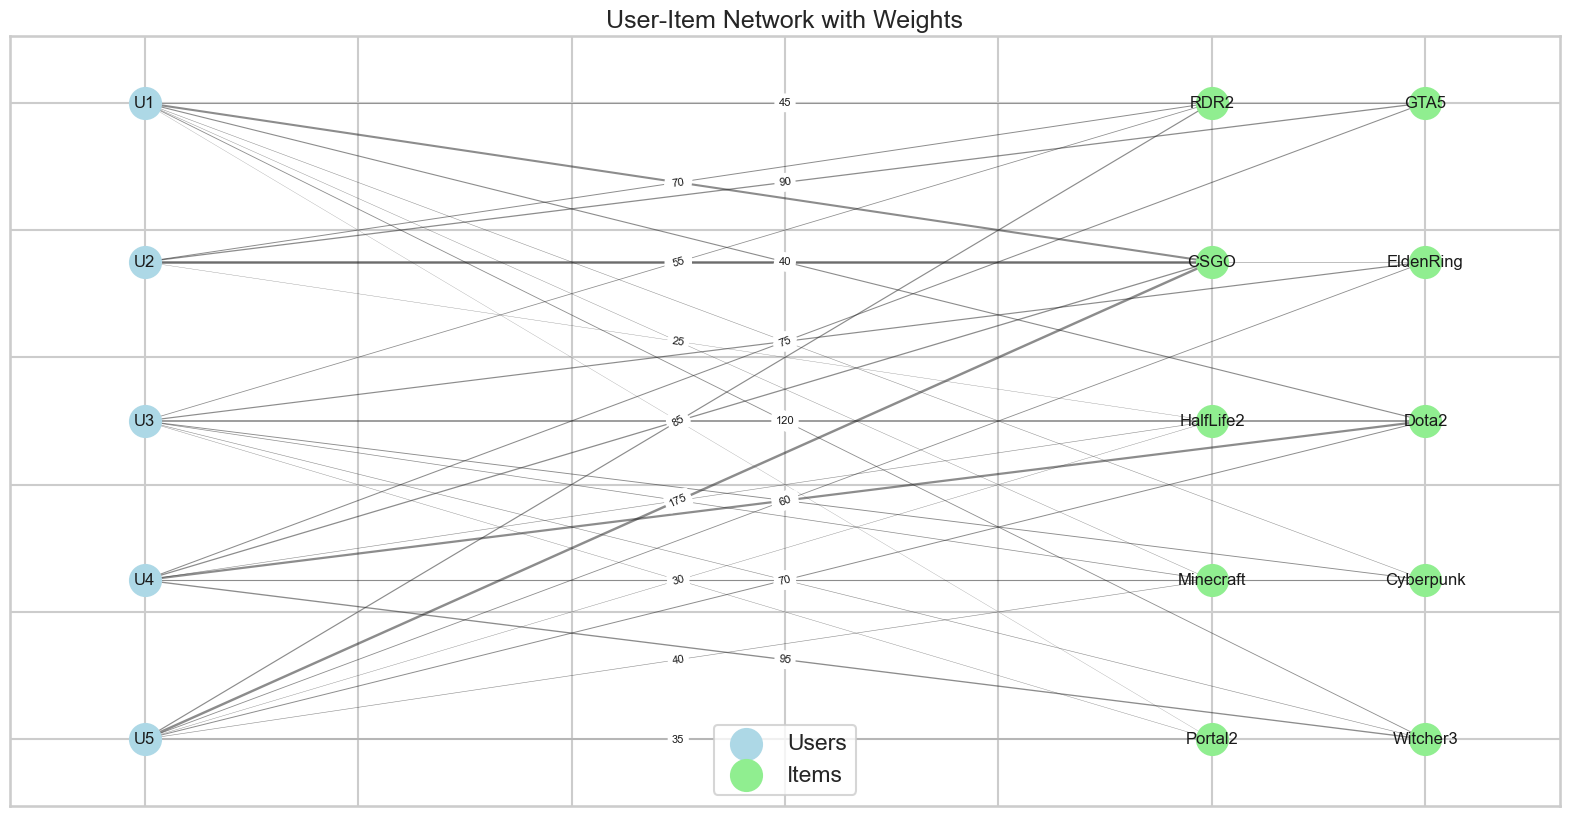

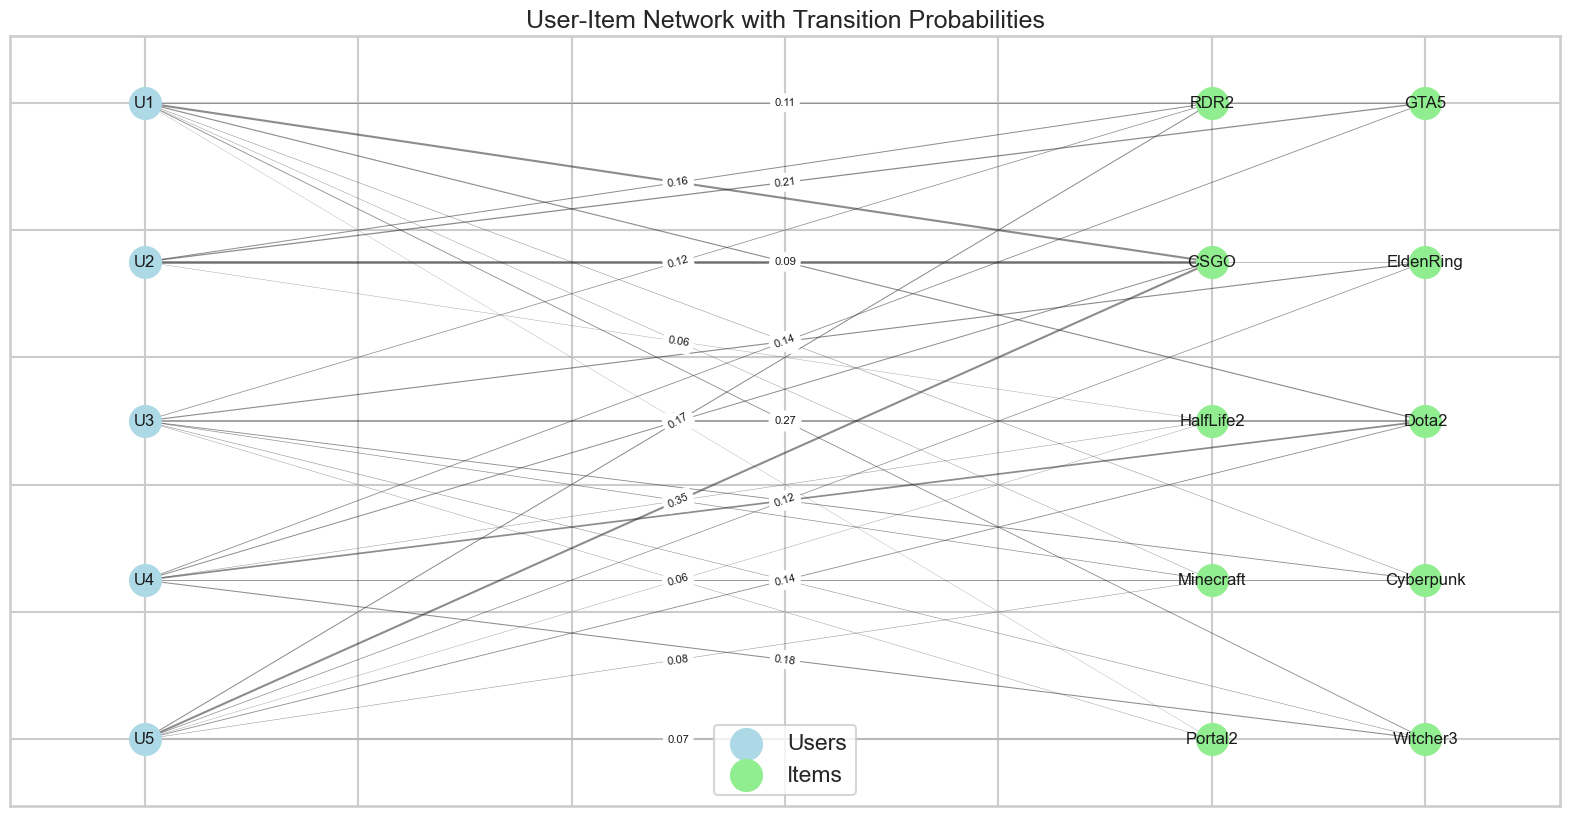

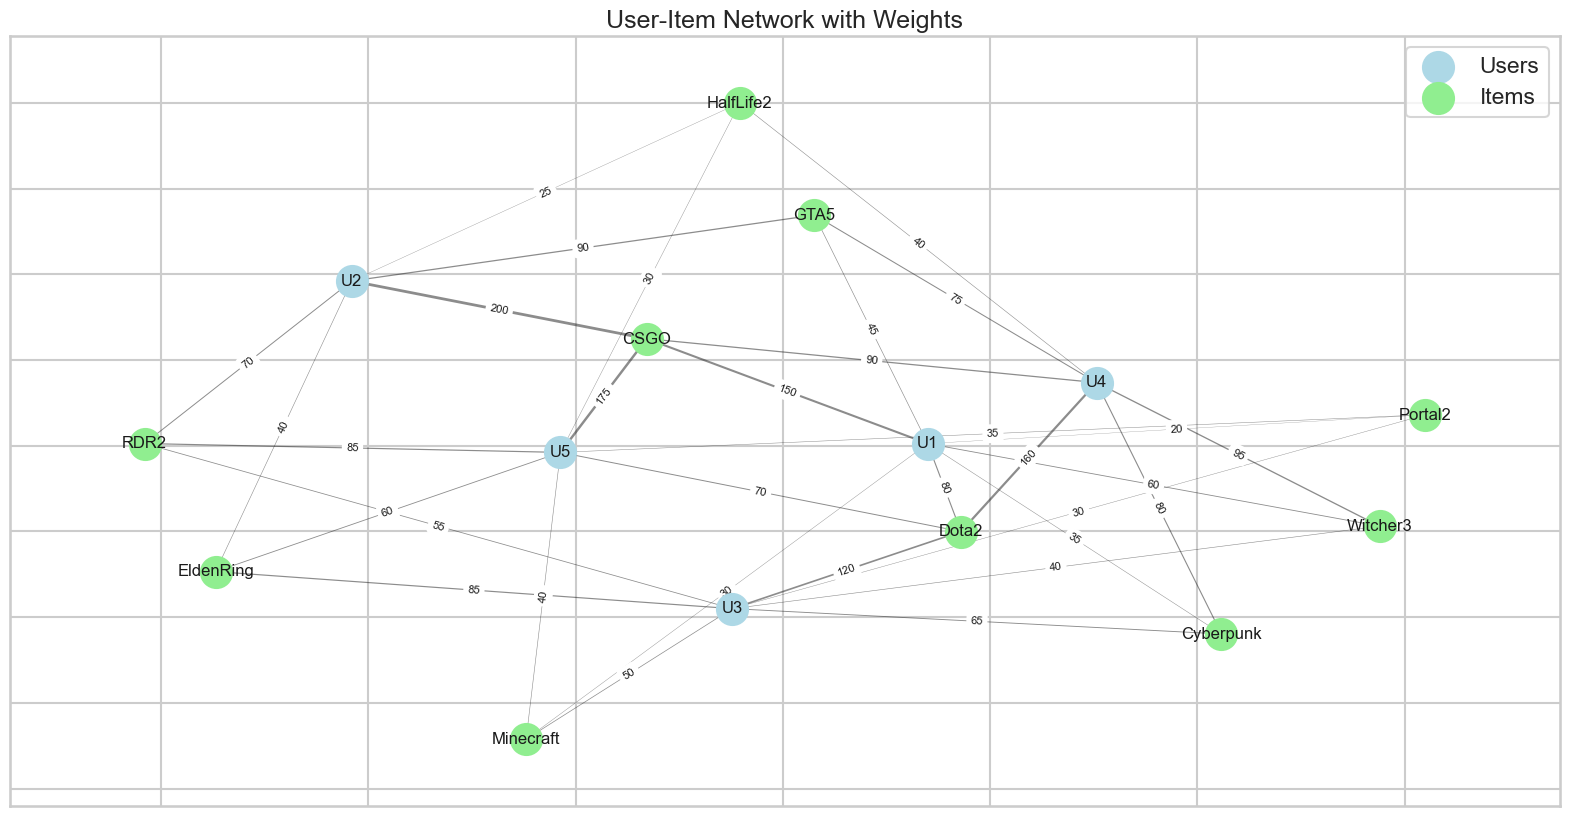

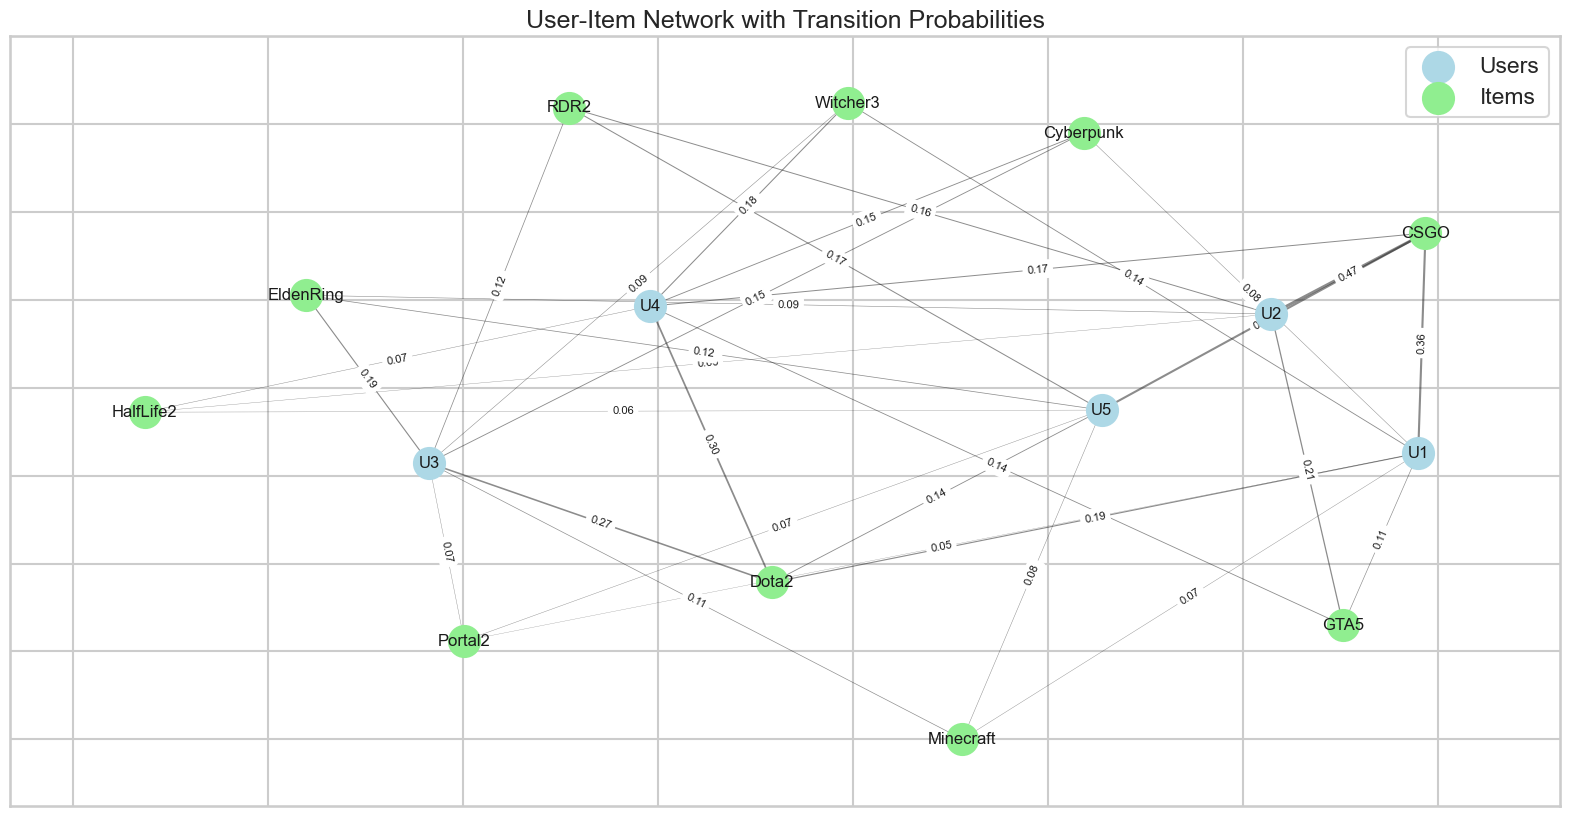

In [8]:
item_data = {
    'U1': {'CSGO': 150, 'Dota2': 80, 'Minecraft': 30, 'GTA5': 45, 
           'Witcher3': 60, 'Portal2': 20, 'Cyberpunk': 35},
    'U2': {'CSGO': 200, 'EldenRing': 40, 'GTA5': 90, 'RDR2': 70, 
           'HalfLife2': 25},
    'U3': {'Dota2': 120, 'EldenRing': 85, 'Minecraft': 50, 'RDR2': 55,
           'Witcher3': 40, 'Portal2': 30, 'Cyberpunk': 65},
    'U4': {'CSGO': 90, 'Dota2': 160, 'GTA5': 75, 'Witcher3': 95,
           'HalfLife2': 40, 'Cyberpunk': 80},
    'U5': {'CSGO': 175, 'Dota2': 70, 'EldenRing': 60, 'Minecraft': 40,
           'RDR2': 85, 'Portal2': 35, 'HalfLife2': 30}
}

# Create visualizations with fixed layout
plt1 = createItemGraphsFixed(item_data, normalize_weights=False)
plt1.savefig('../output/images/item_network_fixed.png', bbox_inches='tight', dpi=360)

plt2 = createItemGraphsFixed(item_data, normalize_weights=True)
plt2.savefig('../output/images/transition_network_fixed.png', bbox_inches='tight', dpi=360)

# Create visualizations with spring layout
plt3 = createItemGraphs(item_data, normalize_weights=False)
plt3.savefig('../output/images/item_network_spring.png', bbox_inches='tight', dpi=360)

plt4 = createItemGraphs(item_data, normalize_weights=True)
plt4.savefig('../output/images/transition_network_spring.png', bbox_inches='tight', dpi=360)